# Neural Network Performance on Affinity Propagation Clustering

### Import Packages

In [1]:
# tensorflow model imports
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# keras imports
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout

# sklearn modeling imports
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import AffinityPropagation, KMeans, SpectralClustering

# other imports
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/spotify_tracks_genre.csv')

### Data Preprocessing

In [4]:
data = data.drop(labels = ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name'],
                 axis = 1)

data["explicit"] = data["explicit"].replace({True:1, False:0})

# adding one-hot encoding of our categorical column time signature and key
data = pd.get_dummies(data, columns = ["time_signature","key"])

In [5]:
data

,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,73,230666,0,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,...,0,0,0,0,0,0,0,0,0,0
1,55,149610,0,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,...,0,0,0,0,0,0,0,0,0,0
2,57,210826,0,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,71,201933,0,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,...,0,0,0,0,0,0,0,0,0,0
4,82,198853,0,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,21,384999,0,0.172,0.2350,-16.393,1,0.0422,0.6400,0.928000,...,0,0,0,1,0,0,0,0,0,0
113996,22,385000,0,0.174,0.1170,-18.318,0,0.0401,0.9940,0.976000,...,0,0,0,0,0,0,0,0,0,0
113997,22,271466,0,0.629,0.3290,-10.895,0,0.0420,0.8670,0.000000,...,0,0,0,0,0,0,0,0,0,0
113998,41,283893,0,0.587,0.5060,-10.889,1,0.0297,0.3810,0.000000,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# Affinity Propagation

average_traits_by_genre = data.groupby('track_genre').mean()

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(average_traits_by_genre)

data_scaled = pd.DataFrame(scaled_features, columns=average_traits_by_genre.columns,
                           index=average_traits_by_genre.index)

aff_prop = AffinityPropagation()
average_traits_by_genre['cluster'] = aff_prop.fit_predict(data_scaled)
num_clusters = 16

#display clusters
for cluster in range(num_clusters):
    print(f"Cluster {cluster}:")
    genres_in_cluster = average_traits_by_genre[average_traits_by_genre['cluster'] == cluster].index.tolist()
    print(genres_in_cluster)
    print()

Cluster 0:
['breakbeat', 'chicago-house', 'detroit-techno']

Cluster 1:
['comedy']

Cluster 2:
['dancehall', 'funk', 'j-dance']

Cluster 3:
['black-metal', 'death-metal', 'grindcore', 'metalcore']

Cluster 4:
['afrobeat', 'disco', 'forro', 'kids', 'party', 'rock', 'salsa', 'synth-pop']

Cluster 5:
['anime', 'club', 'deep-house', 'dub', 'dubstep', 'electro', 'electronic', 'emo', 'french', 'groove', 'hardcore', 'hardstyle', 'industrial', 'j-idol', 'k-pop', 'progressive-house', 'turkish']

Cluster 6:
['alt-rock', 'alternative', 'brazil', 'garage', 'goth', 'grunge', 'hard-rock', 'heavy-metal', 'j-rock', 'metal', 'power-pop', 'punk', 'punk-rock', 'spanish']

Cluster 7:
['idm', 'iranian', 'study']

Cluster 8:
['acoustic', 'blues', 'cantopop', 'chill', 'country', 'folk', 'german', 'indian', 'indie', 'indie-pop', 'j-pop', 'jazz', 'malay', 'mandopop', 'pop', 'pop-film', 'r-n-b', 'sad', 'show-tunes', 'singer-songwriter', 'songwriter', 'soul', 'swedish', 'world-music']

Cluster 9:
['bluegrass', '

In [7]:
# relabeling genres
for i in range(num_clusters):
  genres_in_cluster = average_traits_by_genre[average_traits_by_genre['cluster'] == i].index.tolist()
  if len(genres_in_cluster) == 0:
    break
  data = data.replace(genres_in_cluster, i)

# undersampling 1000 from each cluster
sampled_df = pd.DataFrame()
n = len(data["track_genre"].unique())
for i in range(n): # sample 1000
  cluster = data[data["track_genre"] == i]
  samples = cluster.sample(1000)
  sampled_df = pd.concat([sampled_df, samples], axis=0)

data = sampled_df

In [8]:
# train test split
X = data.drop(labels=['track_genre'], axis=1)
y = data['track_genre']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

n = int(len(data)/1000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Model Construction

In [9]:
# FCNN model
num_features = X_train.shape[1]
num_genres = np.unique(y_train).shape[0]

def create_model(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(512, activation=activation, input_shape=(num_features,)))
    model.add(Dense(256, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = activation))
    model.add(Dense(num_genres, activation = 'softmax'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [10]:
model = create_model()

### Training

In [11]:
# scheduler to fine tune model learning
def scheduler(epoch, lr):
  return lr*0.9

callback = keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(X_train, y_train, batch_size = 32, verbose=1, epochs=20,
           validation_split=0.1, callbacks = [callback])

Epoch 1/20
360/360 [==============================] - 3s 6ms/step - loss: 1.8108 - accuracy: 0.3956 - val_loss: 1.8224 - val_accuracy: 0.3922 - lr: 9.0000e-04
Epoch 2/20
360/360 [==============================] - 2s 7ms/step - loss: 1.5903 - accuracy: 0.4707 - val_loss: 1.5559 - val_accuracy: 0.4680 - lr: 8.1000e-04
Epoch 3/20
360/360 [==============================] - 3s 8ms/step - loss: 1.5184 - accuracy: 0.4938 - val_loss: 1.5770 - val_accuracy: 0.4727 - lr: 7.2900e-04
Epoch 4/20
360/360 [==============================] - 2s 5ms/step - loss: 1.4652 - accuracy: 0.5129 - val_loss: 1.5303 - val_accuracy: 0.4883 - lr: 6.5610e-04
Epoch 5/20
360/360 [==============================] - 2s 5ms/step - loss: 1.4279 - accuracy: 0.5227 - val_loss: 1.4857 - val_accuracy: 0.5023 - lr: 5.9049e-04
Epoch 6/20
360/360 [==============================] - 2s 5ms/step - loss: 1.3953 - accuracy: 0.5283 - val_loss: 1.4762 - val_accuracy: 0.4984 - lr: 5.3144e-04
Epoch 7/20
360/360 [==========================

### Testing

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

100/100 [==============================] - 0s 3ms/step - loss: 1.4251 - accuracy: 0.5497
Test Loss: 1.4250617027282715
Test Accuracy: 0.5496875047683716


### Evaluation

100/100 [==============================] - 0s 3ms/step


Text(50.722222222222214, 0.5, 'True Label')

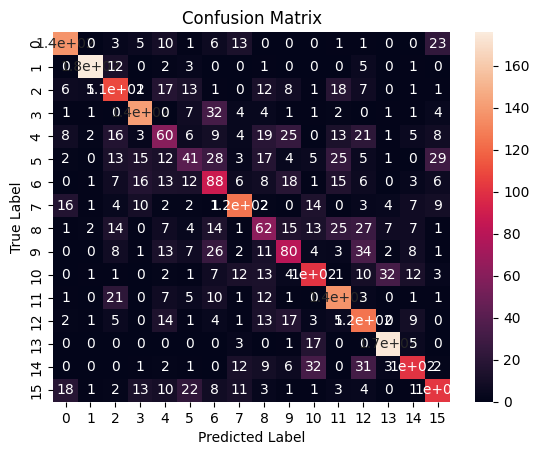

In [13]:
# confusion matrix to evaluate predictions
ypred = model.predict(X_test).argmax(axis=1)
cf_matrix = sklearn.metrics.confusion_matrix(y_test, ypred)
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

We can evaluate our model from the confusion matrix and observe that clusters 1 and 13 were consistently predicted well, and then after further inspection we see that both of these clusters only have one genre in them. Which means that both our clustering algorithm and our model was able to detect features very unique to these particular genres and identify them consistently. On the other hand, our model did not provide great predictions for the clusters 4, 5, and 8. All of these clusters are relatively large compared to the other ones, with 8 being the largest. In cluster 8, we see genres such as "germany", "malay", "swedish", and "singer-songwriter" which are less definite genres and the variability amongst them is likely why our model was not able to predict them as accurately.


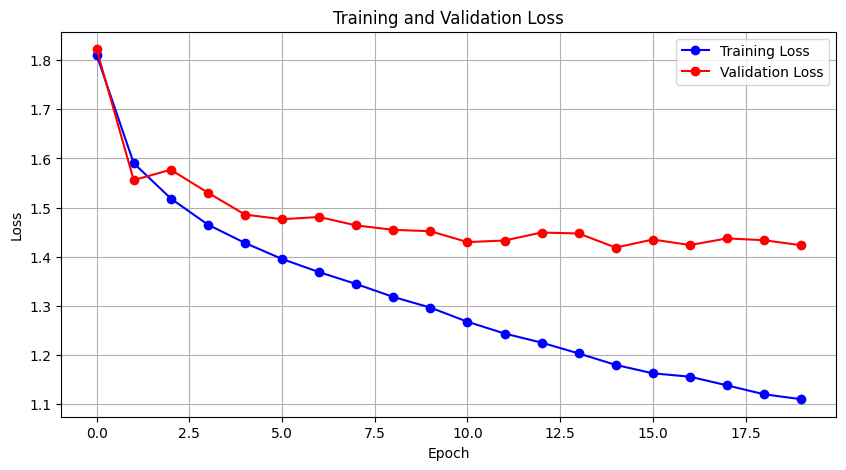

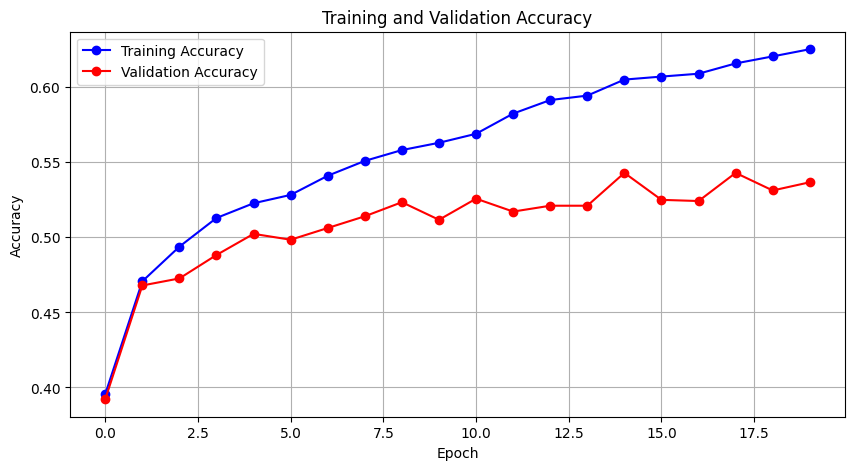

In [14]:
# extracting training and validation loss from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# extracting training and validation accuracy from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(val_loss, label='Validation Loss', color='red', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy', color='blue', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', color='red', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()